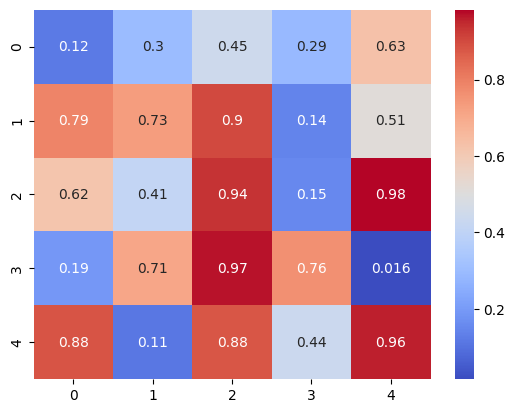

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = np.random.rand(5, 5)

sns.heatmap(data, annot=True, cmap='coolwarm')
plt.show()



In [3]:
data = np.random.rand(5, 5, 4)
print(data)

[[[0.49569    0.68707635 0.62484289 0.82666073]
  [0.81171115 0.91247694 0.21652549 0.09530202]
  [0.65230645 0.32784146 0.79757541 0.46282102]
  [0.3470972  0.75060447 0.95135157 0.18326506]
  [0.78175934 0.38522751 0.77998845 0.87436935]]

 [[0.52296473 0.24968117 0.92327636 0.83411592]
  [0.36313958 0.85139014 0.23153425 0.62799228]
  [0.98044568 0.02304536 0.89934814 0.28673131]
  [0.57276976 0.05220006 0.29845859 0.71666271]
  [0.25759641 0.4601256  0.11296367 0.00876655]]

 [[0.77455391 0.19046461 0.22548924 0.36357442]
  [0.65574327 0.15148602 0.401947   0.63221657]
  [0.73344486 0.19660406 0.41450736 0.64188714]
  [0.52840466 0.50771696 0.94439764 0.13628881]
  [0.30645265 0.23662302 0.86750342 0.84874586]]

 [[0.69449789 0.79801968 0.33697075 0.45474427]
  [0.93027989 0.77943639 0.47161356 0.99980576]
  [0.08641342 0.45420676 0.96721345 0.6381118 ]
  [0.39134178 0.46652934 0.13394151 0.32443823]
  [0.62610631 0.91564069 0.20702023 0.72066866]]

 [[0.78118896 0.86456975 0.47358

In [4]:
data1 = data[:, :, :2]
print(data1)

[[[0.49569    0.68707635]
  [0.81171115 0.91247694]
  [0.65230645 0.32784146]
  [0.3470972  0.75060447]
  [0.78175934 0.38522751]]

 [[0.52296473 0.24968117]
  [0.36313958 0.85139014]
  [0.98044568 0.02304536]
  [0.57276976 0.05220006]
  [0.25759641 0.4601256 ]]

 [[0.77455391 0.19046461]
  [0.65574327 0.15148602]
  [0.73344486 0.19660406]
  [0.52840466 0.50771696]
  [0.30645265 0.23662302]]

 [[0.69449789 0.79801968]
  [0.93027989 0.77943639]
  [0.08641342 0.45420676]
  [0.39134178 0.46652934]
  [0.62610631 0.91564069]]

 [[0.78118896 0.86456975]
  [0.45687918 0.13451761]
  [0.77558261 0.95197665]
  [0.60529227 0.65912194]
  [0.40415815 0.02707841]]]
